**NLP Analysis - Reviews Data**

# Introduction

## Read in libraries, data, and set notebook preferences

**Read in libraries**

In [53]:
#Read in libraries
import pandas as pd
import swifter

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

**Read in data**

In [54]:
#Set path to data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\03_Processed'

#Read in data
df = pd.read_csv(path + '/2020_0208_Reviews_Processed_NLP.csv',sep=',',
                 parse_dates=['date'])

**Set preferences for notebook**

In [55]:
#Ignore warnings
import warnings; warnings.simplefilter('ignore')

#Increase number of columns and rows displayed by Pandas
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',100)

#Set style for plots
plt.style.use('seaborn')

## Preview data

In [56]:
#Preview data and shape
print('Reviews data shape:', df.shape)
display(df.head())

Reviews data shape: (425509, 6)


,comments,date,sentiment_compound,label,word_count,comments_pos_tag
0,"Hello Josh Thank you very much for everything. I found myself very comfortable in your home. Quiet, comfortable and very complete and very clean, which I value highly. Next time I'd come with my family. I hope it's possible.",2013-12-01,0.9534,positive,39,"[('hello', 'NN'), ('josh', 'NN'), ('thank', 'VBD'), ('much', 'JJ'), ('everything', 'NN'), ('comfortable', 'JJ'), ('home', 'NN'), ('quiet', 'RBR'), ('comfortable', 'JJ'), ('complete', 'JJ'), ('clean', 'JJ'), ('highly', 'RB'), ('next', 'JJ'), ('time', 'NN'), ('come', 'VBN'), ('possible', 'JJ')]"
1,"Stop and book it now. Rea (Website hidden by Airbnb) this later!!! If your a single person looking for a story book San Francisco experience, look no farther. Staying in Mikes place couldn't be any more wonderful. If your familiar with ""Tales of the City"" Mike is the Olympia Dukakis. The home is warm and inviting with all the nuances of an old Victorian. Mike is an amazing host . He can tell you how walk drive or public transit the city (don't bother with a car). Would love to keep the gem to myself but everyone deserves this unique place to lay your head. Make sure while you're there be introduced to William . Book IT you won't be disappointed .",2017-06-07,0.9334,positive,122,"[('stop', 'VB'), ('book', 'NN'), ('rea', 'JJ'), ('website', 'RB'), ('hidden', 'VBP'), ('later', 'RB'), ('person', 'NN'), ('looking', 'VBG'), ('book', 'NN'), ('san', 'JJ'), ('francisco', 'JJ'), ('experience', 'NN'), ('look', 'NN'), ('staying', 'VBG'), ('place', 'NN'), ('wonderful', 'NN'), ('familiar', 'JJ'), ('tales', 'NNS'), ('city', 'NN'), ('mike', 'NN'), ('olympia', 'VBP'), ('dukakis', 'NN'), ('home', 'NN'), ('inviting', 'NN'), ('nuances', 'NNS'), ('old', 'JJ'), ('victorian', 'JJ'), ('mike', 'NN'), ('amazing', 'VBG'), ('host', 'NN'), ('tell', 'NN'), ('walk', 'VBP'), ('drive', 'JJ'), ('transit', 'NN'), ('city', 'NN'), ('would', 'MD'), ('love', 'VB'), ('gem', 'NN'), ('everyone', 'NN'), ('deserves', 'VBZ'), ('unique', 'JJ'), ('place', 'NN'), ('head', 'NN'), ('make', 'VBP'), ('sure', 'JJ'), ('book', 'NN'), ('disappointed', 'VBD')]"
2,"So I moved to SF in late May from Michigan to intern at Genentech for the summer. I stayed at Anjan’s apartment for 7 days while I was looking for a more permanent housing situation. Anjan was extremely hospitable and welcoming throughout the week. He was also very knowledgeable about the area and always offered to help in any way that he could. The area (SOMA) is very safe and is very “walkable.” There are plenty of restaurants and stores nearby (there’s even a target a few blocks away), so you have everything you need within a couple blocks from the apartment. As for the bedroom, it was spacious and clean. The bathroom was nice and I had to myself for the entirety of my stay. I felt very comfortable living at Anjan’s for a week and I really enjoyed staying there. If you’re a respectful person and are looking for a place to stay in SF for a short time, I highly recommend staying at Anjan’s. He’s a great person and a great host.",2013-06-02,0.9860,positive,175,"[('moved', 'VBN'), ('may', 'MD'), ('michigan', 'VB'), ('summer', 'NN'), ('days', 'NNS'), ('looking', 'VBG'), ('permanent', 'JJ'), ('housing', 'NN'), ('situation', 'NN'), ('anjan', 'VBZ'), ('extremely', 'RB'), ('hospitable', 'JJ'), ('welcoming', 'VBG'), ('throughout', 'IN'), ('week', 'NN'), ('also', 'RB'), ('knowledgeable', 'JJ'), ('area', 'NN'), ('always', 'RB'), ('offered', 'VBD'), ('way', 'NN'), ('area', 'NN'), ('soma', 'NN'), ('safe', 'JJ'), ('walkable', 'JJ'), ('plenty', 'NN'), ('stores', 'NNS'), ('nearby', 'JJ'), ('blocks', 'NNS'), ('away', 'RP'), ('everything', 'NN'), ('need', 'NN'), ('within', 'IN'), ('blocks', 'NNS'), ('apartment', 'JJ'), ('bedroom', 'NN'), ('spacious', 'JJ'), ('clean', 'JJ'), ('bathroom', 'NN'), ('nice', 'JJ'), ('entirety', 'NN'), ('stay', 'NN'), ('comfortable', 'JJ'), ('living', 'NN'), ('enjoyed', 'VBD'), ('staying', 'VBG'),

# Data Exploration

### Histogram of sentiment scores

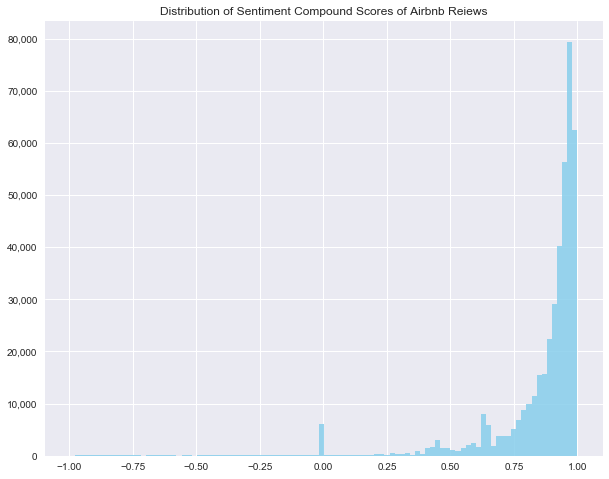

In [57]:
#Set plot
fig, ax = plt.subplots(figsize = (10,8))

#Plot hist of sentiment_compound scores
j = df.sentiment_compound.hist(ax = ax,bins = 100, color = 'skyblue', alpha = .85)

#Set plot aesthetics
j.set_title('Distribution of Sentiment Compound Scores of Airbnb Reiews')
ax.set_yticklabels(['{:,}'.format(int(y)) for y in ax.get_yticks()]);

### Positive, neutral, and negative review counts

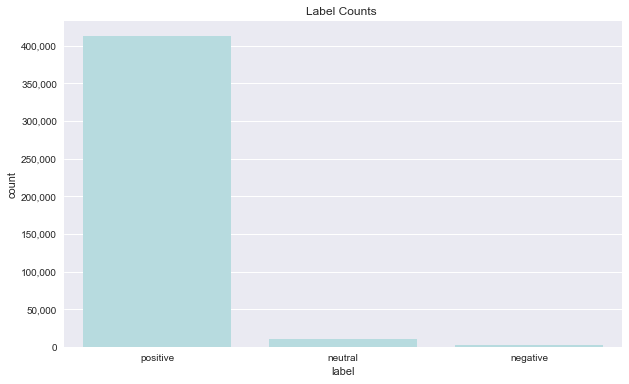

In [58]:
#Set plot
fig, ax = plt.subplots(figsize=(10,6))

#plot data
g =sns.countplot(x='label', data = df,order = ['positive', 'neutral', 'negative'], color='powderblue')

#Set plot aesthetics
g.set_title('Label Counts ')
g.set_yticklabels(['{:,}'.format(int(y)) for y in ax.get_yticks()]);

### Create positive and negative dataframes and corpora 

In [59]:
#Create pos/negative df's
pos_df = df[df.label == 'positive']
neg_df = df[df.label == 'negative']

#Create pos/neg corpora
pos_comments = pos_df['comments'].tolist()
neg_comments = neg_df['comments'].tolist()

### Distribution of review lengths for positive and negative reviews

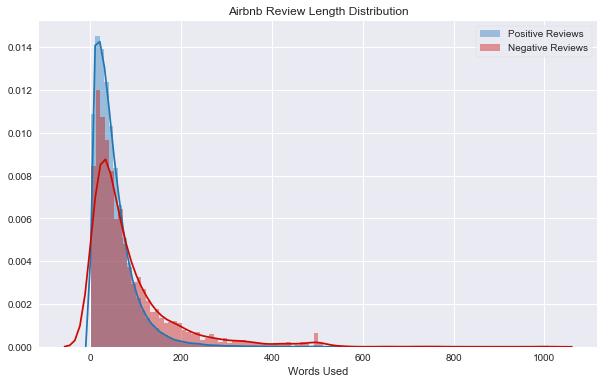

In [60]:
#Set plot
fig, ax = plt.subplots(figsize=(10,6))

#Plot Histograms for word count
sns.distplot(pos_df.word_count, kde = True, bins = 100, color = 'tab:blue', ax=ax)
sns.distplot(neg_df.word_count, kde = True, bins = 100, color = 'r', ax=ax)

#Set plot aesthetics
ax.legend(labels = ['Positive Reviews', 'Negative Reviews', 'Neutral Reviews'], frameon = True);
ax.set_title('Airbnb Review Length Distribution')
ax.set_xlabel('Words Used');

### Word clouds of positive and negative reviews

In [61]:
#Import libraries 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

**Postive Reviews Wordcloud**

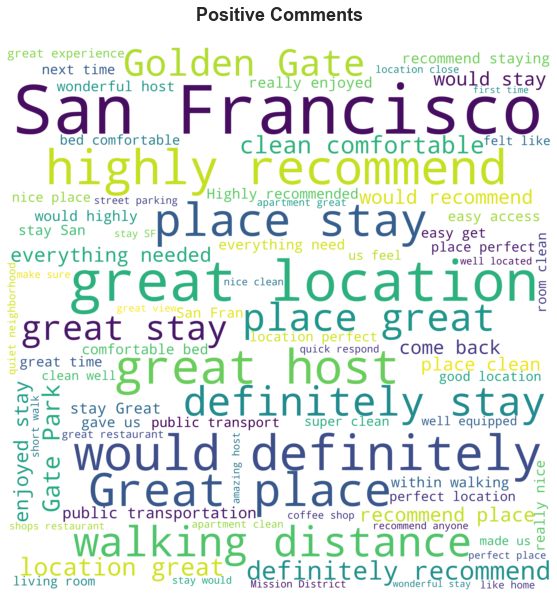

In [62]:
#Import stopwords
from nltk.corpus import stopwords, wordnet
stop_words = stopwords.words('english')

#Add additional stop words
stop_words.extend(['airbnb','website hidden by airbnb'])

#Create wordcloud for postive reviews
wordcloud = WordCloud(max_font_size=500, max_words=80, background_color="white", stopwords=stop_words,
                      width= 4000, height = 4000).generate(str(pos_comments))

#Plot data and set plot aesthetics
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Positive Comments\n', fontsize=18, fontweight='bold')
plt.show()

**Negative Reviews Wordcloud**

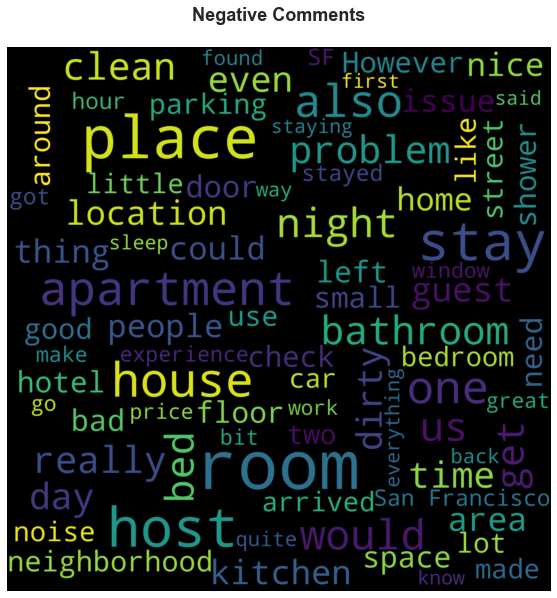

In [63]:
#Create wordcloud for postive reviews
wordcloud = WordCloud(max_font_size=500, max_words=80, background_color="black",stopwords=stop_words,
                      width= 4000, height = 4000).generate(str(neg_comments))

#Plot data and set plot aesthetics
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Negative Comments\n', fontsize=18, fontweight='bold')
plt.show()

**Frequency Distributions**

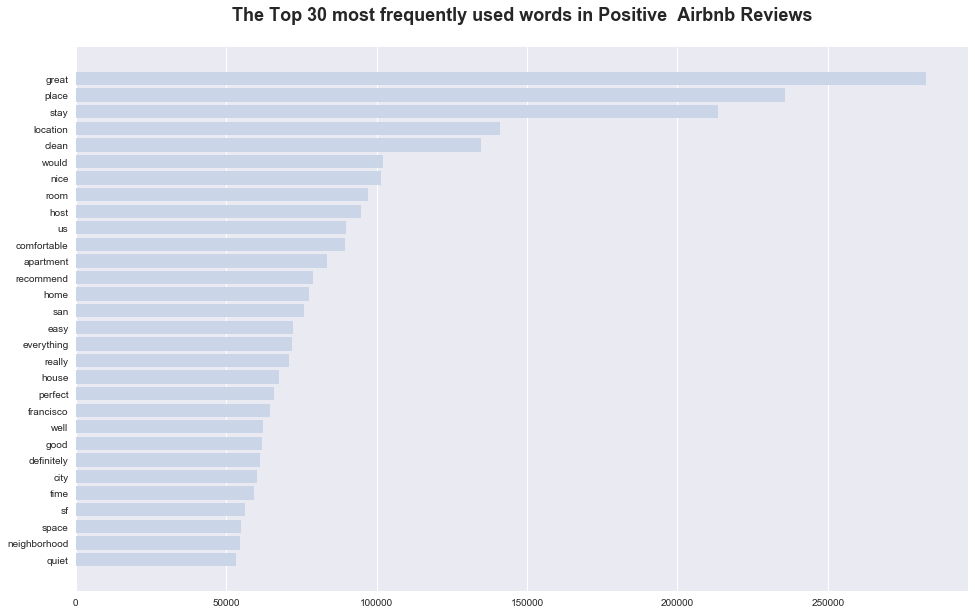

In [64]:
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text.freqdist import FreqDistVisualizer
from yellowbrick.style import set_palette

#Vectorize comments and also remove stop words
cv = CountVectorizer(stop_words=stop_words)
positive_docs = cv.fit_transform(pos_comments)
features = cv.get_feature_names()

#Preparing the plot
set_palette('pastel')
plt.figure(figsize=(16,10))
plt.title('The Top 30 most frequently used words in Positive  Airbnb Reviews\n', fontsize = 18, fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30, orient='h')
visualizer.fit(positive_docs)
visualizer.poof;

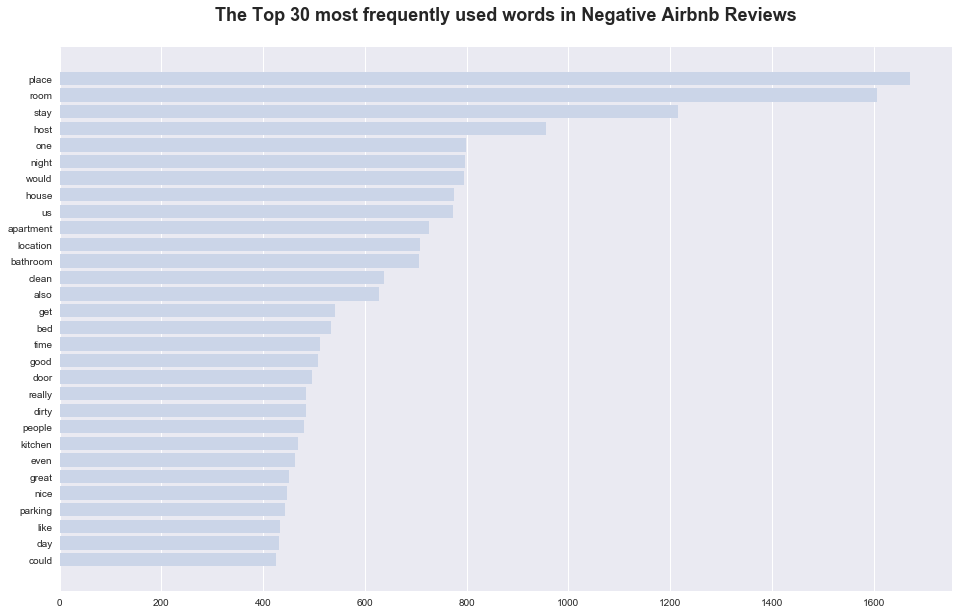

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text.freqdist import FreqDistVisualizer

#Vectorize comments and also remove stop words
cv = CountVectorizer(stop_words=stop_words)
negative_docs = cv.fit_transform(neg_comments)
features = cv.get_feature_names()

#Preparing the plot
plt.figure(figsize=(16,10))
plt.title('The Top 30 most frequently used words in Negative Airbnb Reviews\n', fontsize = 18, fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30, orient='h')
visualizer.fit(negative_docs)
visualizer.poof;

# Topic modeling 

Topic modeling will be performed seperately for positive and negative reviews due to the fact that a large majority of the reviews are positive reviews. Additionally, due to the sheer number of reviews, we will focus our topic analysis on the most positive and negative user experiecnes in the data set

### Import libraries

In [66]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Import spacy for lemmatization
from spacy.lang.en import English
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

#Reg exp
import re

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt

### Data Preparation

In [67]:
#How many really negative and positive reviews are there?
print("Number of reviews with a sentiment score < -.9: ",len(df[df.sentiment_compound < -.9]))
print("Number of reviews with a sentiment score > .9: ",len(df[df.sentiment_compound>.9]))

#Subset all negative reviews < -.9
neg_reviews = df[df.sentiment_compound < -.9]

#Subset 10% of all positive reviews > .9 
pos_reviews = df[df.sentiment_compound >.9][::10]

#Update pos/neg corpora
pos_comments = pos_reviews['comments'].tolist()
neg_comments = neg_reviews['comments'].tolist()

pos_comments[0]

Number of reviews with a sentiment score < -.9:  315
Number of reviews with a sentiment score > .9:  266560


"                                                          Hello Josh  Thank you very much for everything. I found myself very comfortable in your home. Quiet, comfortable and very complete and very clean, which I value highly. Next time I'd come with my family. I hope it's possible."

### Functions for data cleaning and tokenization

In [68]:
#Tokenize each sentence into a list of words and remove punctuation
def tokenizer(raw_reviews):
    for review in raw_reviews:
        yield(gensim.utils.simple_preprocess(review, deacc=True))
        
#Remove stopwords
def remove_stopwords(texts):
    texts = [texts.remove(text) if len(text) <3 else text for text in texts] #remove texts with len <3
    texts = [text for text in texts if text] #Remove None from texts
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

## Topic Modeling for Positive Reviews

### Tokenize a comments

In [69]:
#Tokenize pos_comments and remove puncuation
pos_tokens = list(tokenizer(pos_comments))

#Check
print(pos_tokens[0])

['hello', 'josh', 'thank', 'you', 'very', 'much', 'for', 'everything', 'found', 'myself', 'very', 'comfortable', 'in', 'your', 'home', 'quiet', 'comfortable', 'and', 'very', 'complete', 'and', 'very', 'clean', 'which', 'value', 'highly', 'next', 'time', 'come', 'with', 'my', 'family', 'hope', 'it', 'possible']


**Creating Bigram and Trigram Models**

In [70]:
#Build bigram and trigram models
bigram = gensim.models.Phrases(pos_tokens,min_count=5, threshold=100)#Might need to increse with full data set
trigram = gensim.models.Phrases(bigram[pos_tokens], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [74]:
#Check
print(pos_tokens[2])

['if', 'you', 'would', 'like', 'to', 'walk', 'the', 'city', 'this', 'is', 'the', 'place', 'to', 'be', 'minute', 'walk', 'to', 'more', 'than', 'handful', 'of', 'good', 'places', 'too', 'see', 'and', 'eat', 'the', 'italian', 'district', 'which', 'comprises', 'most', 'of', 'the', 'north', 'beach', 'area', 'had', 'some', 'of', 'the', 'best', 'food', 'my', 'wife', 'and', 'have', 'ever', 'had', 'we', 'used', 'the', 'apartment', 'as', 'home', 'base', 'were', 'out', 'most', 'of', 'the', 'day', 'it', 'was', 'great', 'to', 'have', 'this', 'place', 'within', 'nice', 'proximity', 'to', 'be', 'able', 'to', 'come', 'back', 'to', 'regroup', 'and', 'then', 'head', 'out', 'for', 'dinner', 'or', 'our', 'next', 'excursion', 'for', 'the', 'given', 'day', 'the', 'studio', 'amenities', 'were', 'perfect', 'for', 'us', 'no', 'problems', 'with', 'space', 'issues', 'or', 'otherwise', 'if', 'you', 'are', 'looking', 'to', 'live', 'like', 'local', 'in', 'san', 'francisco', 'this', 'is', 'probably', 'the', 'best', 

In [77]:
print(trigram_mod[bigram_mod[pos_tokens[2]]])

['when', 'left', 'phil', 'yesterday', 'morning', 'at', 'west_portal', 'we', 'hugged', 'this', 'is', 'my', 'second', 'time', 'staying', 'with', 'phil', 'only', 'this', 'time', 'had', 'the', 'garden', 'suite', 'which', 'believe', 'he', 'was', 'creating', 'last', 'year', 'think', 'we', 'have', 'become', 'friends', 'maybe', 'an', 'odd', 'combo', 'jewish', 'bubbi', 'from', 'brooklyn', 'going', 'to', 'be', 'this', 'year', 'and', 'he', 'asian', 'american', 'and', 'much', 'much', 'younger', 'but', 'think', 'we', 're', 'friends', 'phil', 'warm', 'and', 'open', 'the', 'space', 'he', 'makes', 'in', 'his', 'home', 'is', 'one', 'he', 'has', 'in', 'his', 'heart', 'his', 'heart', 'embraces', 'nature', 'and', 'the', 'inner', 'space', 'he', 'creates', 'reflects', 'his', 'love', 'of', 'being', 'in', 'natural', 'environment', 'it', 'uses', 'light', 'and', 'shadow', 'wood', 'tones', 'and', 'clean', 'lines', 'to', 'provide', 'open', 'space', 'place', 'in', 'which', 'to', 'pause', 'and', 'find', 'serenity',

Remove stopwords, create trigrams, and lemmatize

In [80]:
#Remove stopwords from pos_tokens
pos_tokens_clean = remove_stopwords(pos_tokens)

#check
print(pos_tokens_clean[2])

['left', 'phil', 'yesterday', 'morning', 'west', 'portal', 'hugged', 'second', 'time', 'staying', 'phil', 'time', 'garden', 'suite', 'believe', 'creating', 'last', 'year', 'think', 'become', 'friends', 'maybe', 'odd', 'combo', 'jewish', 'bubbi', 'brooklyn', 'going', 'year', 'asian', 'american', 'much', 'much', 'younger', 'think', 'friends', 'phil', 'warm', 'open', 'space', 'makes', 'home', 'one', 'heart', 'heart', 'embraces', 'nature', 'inner', 'space', 'creates', 'reflects', 'love', 'natural', 'environment', 'uses', 'light', 'shadow', 'wood', 'tones', 'clean', 'lines', 'provide', 'open', 'space', 'place', 'pause', 'find', 'serenity', 'think', 'meditative', 'moment', 'woods', 'sunshine', 'utilitarian', 'nothing', 'omitted', 'serve', 'better', 'describe', 'allotted', 'space', 'slept', 'well', 'memory', 'foam', 'mattress', 'totally', 'comfortable', 'provided', 'everything', 'heart', 'could', 'desire', 'space', 'actually', 'lifted', 'mood', 'made', 'joyous', 'website', 'hidden', 'example'

In [81]:
#Create functions to create bi/trigrams.
def bigrams(tokens):
    return[bigram_mod[token] for token in tokens]

def trigrams(tokens):
    return[trigram_mod[bigram_mod[token]] for token in tokens]

In [106]:
trigrams = trigrams(pos_tokens_clean)

In [108]:
#check
print(trigrams[0:2])

[['hello', 'josh', 'thank', 'much', 'everything', 'found', 'comfortable', 'home', 'quiet', 'comfortable', 'complete', 'clean', 'value', 'highly', 'next', 'time', 'come', 'family', 'hope', 'possible'], ['would', 'like', 'walk', 'city', 'place', 'minute', 'walk', 'handful', 'good', 'places', 'see', 'eat', 'italian', 'district', 'comprises', 'north_beach', 'area', 'best', 'food', 'wife', 'ever', 'used', 'apartment', 'home', 'base', 'day', 'great', 'place', 'within', 'nice', 'proximity', 'able', 'come', 'back', 'regroup', 'head', 'dinner', 'next', 'excursion', 'given', 'day', 'studio', 'amenities', 'perfect', 'us', 'problems', 'space', 'issues', 'otherwise', 'looking', 'live', 'like', 'local', 'san', 'francisco', 'probably', 'best', 'area', 'equally', 'spaced', 'fishermans_wharf', 'financial_district', 'union_square', 'lombards', 'st', 'many', 'points', 'interest', 'walking', 'hill', 'way', 'home', 'dinner', 'would', 'usually', 'stop', 'one', 'bodega', 'grab', 'bottle', 'wine', 'nightcap',

In [100]:
lemmatized_text = []
def lemmatization(texts, pos_tags = ['NOUN', 'ADJ', 'VERB', 'ADV']):
 #   lemmatized_text = []
    for item in texts:
        doc = nlp(" ".join(item))
        lemmatized_text.append([token.lemma_ for token in doc if token.pos_ in pos_tags])
    return lemmatized_text

In [113]:
# Initialize spacy 'en' model keeping only tagger component 
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(list(trigrams),pos_tags = ['NOUN', 'ADJ', 'VERB', 'ADV'])

In [118]:
#check
print((data_lemmatized[2]))

['leave', 'yesterday', 'morning', 'hug', 'second', 'time', 'stay', 'believe', 'create', 'last', 'year', 'think', 'become', 'friend', 'maybe', 'odd', 'combo', 'jewish', 'year', 'much', 'much', 'young', 'think', 'friend', 'open', 'space', 'make', 'home', 'heart', 'heart', 'embrace', 'nature', 'inner', 'space', 'create', 'reflect', 'love', 'natural', 'environment', 'use', 'light', 'shadow', 'wood', 'tone', 'clean', 'line', 'provide', 'open', 'space', 'place', 'pause', 'find', 'serenity', 'think', 'meditative', 'moment', 'wood', 'sunshine', 'utilitarian', 'omit', 'serve', 'better', 'describe', 'allot', 'space', 'sleep', 'well', 'totally', 'comfortable', 'provide', 'heart', 'could', 'desire', 'space', 'actually', 'lift', 'mood', 'make', 'joyous', 'website_hidden', 'example', 'bathroom', 'tile', 'cover', 'shadow', 'create', 'sensation', 'wave', 'shower', 'curtain', 'bubble', 'water', 'floor', 'sand', 'color', 'base', 'sink', 'color', 'driftwood', 'website_hidden', 'shower', 'dispenser', 'won

Append lematized pos words to pos_df

In [121]:
#Assign lemmatized comments to pos_reviews df
pos_reviews['comments_lemmatized'] = data_lemmatized

#Check
pos_reviews.head(1)

,comments,date,sentiment_compound,label,word_count,comments_pos_tag,comments_lemmatized
0,"Hello Josh Thank you very much for everything. I found myself very comfortable in your home. Quiet, comfortable and very complete and very clean, which I value highly. Next time I'd come with my family. I hope it's possible.",2013-12-01,0.9534,positive,39,"[('hello', 'NN'), ('josh', 'NN'), ('thank', 'VBD'), ('much', 'JJ'), ('everything', 'NN'), ('comfortable', 'JJ'), ('home', 'NN'), ('quiet', 'RBR'), ('comfortable', 'JJ'), ('complete', 'JJ'), ('clean', 'JJ'), ('highly', 'RB'), ('next', 'JJ'), ('time', 'NN'), ('come', 'VBN'), ('possible', 'JJ')]","[thank, much, find, comfortable, home, quiet, comfortable, complete, clean, value, highly, next, time, come, family, hope, possible]"


Bag of Words

In [20]:
dictionary = corpora.Dictionary(documents=pos_lemmatized)
print(len(dictionary))

#Filter pos_lemmatized. Remove tokens that apppear in <15 documents and in more than 50% of the documents
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(text) for text in pos_lemmatized]


print('Number of unique words in dictionary for positive reviews:', len(dictionary))

#Preview Bag Of Words for our sample preprocessed document.
bow_doc_1 = bow_corpus[1]
for i in range(len(bow_doc_1)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_1[i][0], 
                                               dictionary[bow_doc_1[i][0]], bow_doc_1[i][1]))

14561
Number of unique words in dictionary for positive reviews: 2759
Word 1 ("come") appears 1 time.
Word 9 ("home") appears 2 time.
Word 13 ("next") appears 1 time.
Word 19 ("able") appears 1 time.
Word 20 ("amenity") appears 1 time.
Word 21 ("apartment") appears 2 time.
Word 22 ("area") appears 2 time.
Word 23 ("back") appears 1 time.
Word 24 ("base") appears 1 time.
Word 25 ("beach") appears 1 time.
Word 26 ("beat") appears 1 time.
Word 27 ("blue") appears 1 time.
Word 28 ("bottle") appears 1 time.
Word 29 ("city") appears 3 time.
Word 30 ("coit") appears 1 time.
Word 31 ("cool") appears 1 time.
Word 32 ("day") appears 2 time.
Word 33 ("dinner") appears 2 time.
Word 34 ("district") appears 3 time.
Word 35 ("eat") appears 1 time.
Word 36 ("enough") appears 1 time.
Word 37 ("equally") appears 1 time.
Word 38 ("ever") appears 1 time.
Word 39 ("excursion") appears 1 time.
Word 40 ("fall") appears 1 time.
Word 41 ("feel") appears 1 time.
Word 42 ("financial") appears 2 time.
Word 43 ("f

TF-IDF

In [21]:
from gensim import models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

#check
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.0681420949295305),
 (1, 0.1698613971240295),
 (2, 0.18771634479541532),
 (3, 0.36896128279526796),
 (4, 0.11849216976269748),
 (5, 0.19910431743056914),
 (6, 0.18338596832407075),
 (7, 0.4198284970385492),
 (8, 0.145551966003703),
 (9, 0.11795447223194443),
 (10, 0.2501766379512611),
 (11, 0.36604443270931963),
 (12, 0.17783237303619034),
 (13, 0.19575265333753628),
 (14, 0.3384259883941252),
 (15, 0.13449695997514965),
 (16, 0.13348818252414463),
 (17, 0.12410758263501996),
 (18, 0.25318426161260615)]


LDA 10 Topics

In [22]:
#create model on bow_corpus
lda_model = gensim.models.LdaMulticore(corpus = bow_corpus, num_topics=10,workers=3, id2word=dictionary)

#explore topics and relative weight
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.013*"park" + 0.013*"apartment" + 0.011*"us" + 0.011*"clean" + 0.010*"room" + 0.010*"place" + 0.010*"host" + 0.010*"home" + 0.009*"location" + 0.009*"get"
Topic: 1 
Words: 0.022*"francisco" + 0.021*"san" + 0.015*"clean" + 0.015*"apartment" + 0.014*"place" + 0.014*"good" + 0.011*"restaurant" + 0.011*"neighborhood" + 0.011*"us" + 0.010*"location"
Topic: 2 
Words: 0.023*"place" + 0.015*"clean" + 0.012*"location" + 0.012*"good" + 0.012*"room" + 0.011*"comfortable" + 0.010*"nice" + 0.010*"need" + 0.009*"walk" + 0.009*"would"
Topic: 3 
Words: 0.031*"place" + 0.017*"check" + 0.017*"easy" + 0.016*"clean" + 0.014*"definitely" + 0.014*"would" + 0.013*"host" + 0.013*"super" + 0.012*"location" + 0.011*"recommend"
Topic: 4 
Words: 0.044*"place" + 0.022*"host" + 0.016*"recommend" + 0.014*"clean" + 0.013*"would" + 0.012*"room" + 0.011*"good" + 0.010*"nice" + 0.009*"san" + 0.009*"apartment"
Topic: 5 
Words: 0.019*"location" + 0.017*"host" + 0.015*"good" + 0.013*"would" + 0.013*"place

In [23]:
#Create plot
pyLDAvis.enable_notebook()

#vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
#vis

In [37]:
#create model on corpus_tfidf
lda_model = gensim.models.LdaMulticore(corpus = corpus_tfidf, num_topics=5,workers=3, id2word=dictionary)

In [39]:
#Compute LDA model perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.


#Compute coherence score for LDA model

#explore topics and relative weight
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Perplexity:  -7.756154369893198
Topic: 0 
Words: 0.007*"wonderful" + 0.006*"place" + 0.006*"location" + 0.006*"host" + 0.005*"home" + 0.005*"comfortable" + 0.005*"nice" + 0.005*"beautiful" + 0.005*"enjoy" + 0.005*"apartment"
Topic: 1 
Words: 0.007*"recommend" + 0.007*"would" + 0.007*"place" + 0.006*"apartment" + 0.006*"clean" + 0.006*"location" + 0.006*"highly" + 0.006*"home" + 0.006*"space" + 0.006*"good"
Topic: 2 
Words: 0.006*"place" + 0.005*"good" + 0.005*"nice" + 0.005*"room" + 0.005*"walk" + 0.005*"easy" + 0.005*"house" + 0.005*"location" + 0.005*"clean" + 0.005*"apartment"
Topic: 3 
Words: 0.006*"place" + 0.006*"clean" + 0.006*"location" + 0.006*"apartment" + 0.006*"good" + 0.006*"host" + 0.006*"room" + 0.005*"nice" + 0.005*"everything" + 0.005*"us"
Topic: 4 
Words: 0.006*"us" + 0.006*"place" + 0.006*"host" + 0.005*"nice" + 0.005*"perfect" + 0.005*"good" + 0.005*"location" + 0.005*"clean" + 0.005*"house" + 0.005*"room"


In [38]:
#Create plot
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, corpus_tfidf, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.000394  0.017799       1        1  24.449022
4     -0.002520  0.013406       2        1  19.575653
1     -0.007186 -0.026829       3        1  19.179089
3     -0.021034  0.000647       4        1  19.133259
0      0.030346 -0.005022       5        1  17.662977, topic_info=              Term        Freq       Total Category  logprob  loglift
290         golden  191.000000  191.000000  Default  30.0000  30.0000
289           gate  194.000000  194.000000  Default  29.0000  29.0000
176      wonderful  541.000000  541.000000  Default  28.0000  28.0000
1409        yesica   38.000000   38.000000  Default  27.0000  27.0000
248      recommend  562.000000  562.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
217   neighborhood   81.389000  447.444061   Topic5  -5.5471   0.0294
71         perfect   84.963081  519.730103   Topic5  -5.5041  -0.0774
93              us   86.721474  567.791931   Topic5  -5.4836  -0.1454
260           room   86.566872  574.552734   Topic5  -5.4854  -0.1590
80             san   82.949371  510.176300   Topic5  -5.5281  -0.0828

[417 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1818      1  0.236747          aaron
1818      3  0.631326          aaron
1818      4  0.157832          aaron
180       1  0.145602  accommodation
180       2  0.119907  accommodation
...     ...       ...            ...
833       1  0.628920           zain
833       2  0.110986           zain
833       3  0.110986           zain
833       4  0.110986           zain
833       5  0.036995           zain

[1091 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 4, 1])

Feature Engineering: N-grams

In [ ]:
#Postive tokens with stop words reoved but not lemmatized pos_tokens_clean
from nltk.util import ngrams
test = list(ngrams(pos_lemmatized,3))

In [ ]:
import nltk
bigrams = nltk.bigrams(pos_lemmatized[0])

print(bigrams)

In [ ]:
fdfdfdfd

In [ ]:
def jjnn_pairs(pos_tokens):
    for token in pos_tokens

In [26]:
df.head(1)

,comments,date,sentiment_compound,label,word_count,comments_pos_tag
0,"Hello Josh Thank you very much for everything. I found myself very comfortable in your home. Quiet, comfortable and very complete and very clean, which I value highly. Next time I'd come with my family. I hope it's possible.",2013-12-01,0.9534,positive,39,"[('hello', 'NN'), ('josh', 'NN'), ('thank', 'VBD'), ('much', 'JJ'), ('everything', 'NN'), ('comfortable', 'JJ'), ('home', 'NN'), ('quiet', 'RBR'), ('comfortable', 'JJ'), ('complete', 'JJ'), ('clean', 'JJ'), ('highly', 'RB'), ('next', 'JJ'), ('time', 'NN'), ('come', 'VBN'), ('possible', 'JJ')]"


In [ ]:
s = "Natural-language processing (NLP) is an area of computer science " \
    "and artificial intelligence concerned with the interactions " \
    "between computers and human (natural) languages."


In [ ]:
#Filter words that occur in less than 10 documents or more than 25% of documents
dictionary.filter_extremes(no_below= 10,no_above=.25 )

print('Number of unique words after removing rare and common words: {}'.format(len(dictionary)))

In [ ]:
#Vectorize data
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
#Initialize Tfidf and fit to corpus
tfidf = models.TfidfModel(corpus)

#Scale and transform corpus
transformed_tfidf = tfidf[corpus]

#Fit transformed data to Lda
lda = models.LdaMulticore(corpus= transformed_tfidf, num_topics=10, id2word=dictionary)

In [ ]:
#Import pyLDAvis to visualize topics found in LDA
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

#Create plot
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
vis

In [ ]:
sdsds

In [37]:
test_comments = list(pos_df['comments'])



Creating Bigram and Trigram Models

In [38]:
#Build bigram and trigram models
bigram = gensim.models.Phrases(test_comments,min_count=2, threshold=100)#Might need to increse with full data set
trigram = gensim.models.Phrases(bigram[test_comments], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

KeyboardInterrupt: 

Make positive bigrams and trigrams

In [ ]:
bigram_mod[0]

In [ ]:
print(bigrams[1])
print('\n',trigrams[1])

In [ ]:
#lemmatize bigrams and trigrams
from nltk.stem import WordNetLemmatizer

#Init WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize(tokens):
    normalized = " ".join(lemmatizer.lemmatize(word) for word in tokens.split())
    return normalized

temp = lemmatize(bigrams)

In [ ]:
temp[1]

In [ ]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#apply lemmatization keeping only noun, adj, vb, adv to bigrams and trigrams
bigrams_lemmatized = lemmatization(bigrams)
trigrams_lemmatized = lemmatization(trigrams)

print(bigrams_lemmatized[:1])

Create the Dictionary and Corpus needed for Topic Modeling

View the topics in LDA model

Visualize 

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(df.comments_lemma)

# # Create Corpus
# texts = data_lemmatized

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]

# # View
# print(corpus[:1])

Top unigrams

Top bigrams

Top Trigrams

In [ ]:
#What are the most popular words in positive reviews?

In [ ]:
#Import count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english').fit(positive_reviews.comments)

print('Vocabulary used in positive reviews: {}'.format(len(count.vocabulary_)))

bow = count.transform(positive_reviews.comments)
sum_words = bow.sum(axis=0)

#we sort a list of tuples that contain the word and their occurrence in the corpus
words_freq = [(word, sum_words[0, idx]) for word, idx in count.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

# Topic modeling and document clustering for postive reviews

In [ ]:
#Import libraries
import gensim
from gensim.parsing.preprocessing import preprocess_string
from gensim.models import Phrases
from gensim import corpora, models, similarities

In [ ]:
#Apply preprocess and stem original comments
docs = np.array(positive_reviews['comments'].apply(preprocess_string))

# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [ ]:
#Create dictionary of tokens and print info
dictionary = corpora.Dictionary(docs)
print('Number of unique words in original documents: {}'.format(len(dictionary)))

**Remove rare or common tokens**

In [ ]:
#Filter words that occur in less than 10 documents or more than 25% of documents
dictionary.filter_extremes(no_below= 10,no_above=.25 )

print('Number of unique words after removing rare and common words: {}'.format(len(dictionary)))

In [ ]:
#Vectorize data
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
#Initialize Tfidf and fit to corpus
tfidf = models.TfidfModel(corpus)

#Scale and transform corpus
transformed_tfidf = tfidf[corpus]

#Fit transformed data to Lda
lda = models.LdaMulticore(corpus= transformed_tfidf, num_topics=10, id2word=dictionary)

In [ ]:
#Import pyLDAvis to visualize topics found in LDA
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

#Create plot
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
vis

**Takeaways**

## Negative Reviews

**Wordcloud of negative comments**

#What are the most popular words in negative reviews?

In [ ]:
#Instantiate CountVectorizer and fit to comments
count = CountVectorizer(stop_words='english').fit(df.comments)

#Print length of unique words in negative comments
print('Vocabulary used in negative reviews: {}'.format(len(count.vocabulary_)))

#Create bag of words from comments
bow = count.transform(negative_reviews.comments)
sum_words = bow.sum(axis=0)

#we sort a list of tuples that contain the word and their occurrence in the corpus
words_freq = [(word, sum_words[0, idx]) for word, idx in count.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [ ]:
#Create df with vocab and their corresponding counts 
negative_words = pd.DataFrame(words_freq, columns =['Word', 'Count']) 

In [ ]:
#Capture the 30 most used words
negative_words = negative_words.head(30)

#Plot
fig,ax = plt.subplots(figsize = (10,10))
negative_words.sort_values(by='Count').plot(x = 'Word',y='Count',kind='barh', ax=ax, color = 'skyblue')

#Set plot aesthetics
ax.set_title('Most Common Words used in Negative Airbnb Reviews')
ax.set_ylabel('')

In [ ]:
#Topic modeling for negative reviews

In [ ]:
#Apply preprocess and stem original comments
docs = np.array(df['comments'].apply(preprocess_string))

# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [ ]:
#Create dictionary of tokens and print info
dictionary = corpora.Dictionary(docs)
print('Number of unique words in original documents: {}'.format(len(dictionary)))

**Remove rare or common tokens**

In [ ]:
#Filter words that occur in less than 10 documents or more than 25% of documents
dictionary.filter_extremes(no_below= 10,no_above=.25 )

print('Number of unique words after removing rare and common words: {}'.format(len(dictionary)))

In [ ]:
#Vectorize data
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
#Initialize Tfidf and fit to corpus
tfidf = models.TfidfModel(corpus)

#Scale and transform corpus
transformed_tfidf = tfidf[corpus]

#Fit transformed data to Lda
lda = models.LdaMulticore(corpus= transformed_tfidf, num_topics=10, id2word=dictionary)

In [ ]:
#Create plot
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
vis

Build classifier that can classify postive and negative reviews
What words are the most important to each?

In [ ]:
#what insights can you gain?

Extract Additional insights from Comments (NLP book chapter 7)